# 제공해준 EDA가 너무 잘되있어서 EDA는 skip하고 bbox viz만

In [2]:
import pandas as pd
import numpy as np
import json
from pycocotools.coco import COCO

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
GT_JSON = '../dataset/train.json'
PRED_CSV = '../sample_submission/train_sample.csv'
LABEL_NAME = ["General trash", "Paper", "Paper pack", "Metal", 
              "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

# load ground truth
with open(GT_JSON, 'r') as outfile:
    test_anno = (json.load(outfile)) 
    # test_anno : 5개의 key('info', 'licenses', 'images', 'categories', 'annotations')들로 이루어진 dict
    # info : dataset 정보?
    # licenses : dataset licenses
    # images : 각 image들의 정보(file 위치, width, height, id <- image의 고유 번호)
    # categories : class 정보 (총 10개의 class)
    # annotations : 모든 iamge들의 annotation정보(category_id와 bbox 좌표)

# load prediction
pred_df = pd.read_csv(PRED_CSV)

In [4]:
image_df = pd.DataFrame(test_anno['images']).set_index('id')
anno_df = pd.DataFrame(test_anno['annotations'])

# EDA

## category

- category description

In [5]:
[str(i['id'])+" : "+i['name'] for i in test_anno['categories']]

['0 : General trash',
 '1 : Paper',
 '2 : Paper pack',
 '3 : Metal',
 '4 : Glass',
 '5 : Plastic',
 '6 : Styrofoam',
 '7 : Plastic bag',
 '8 : Battery',
 '9 : Clothing']

- category distribution

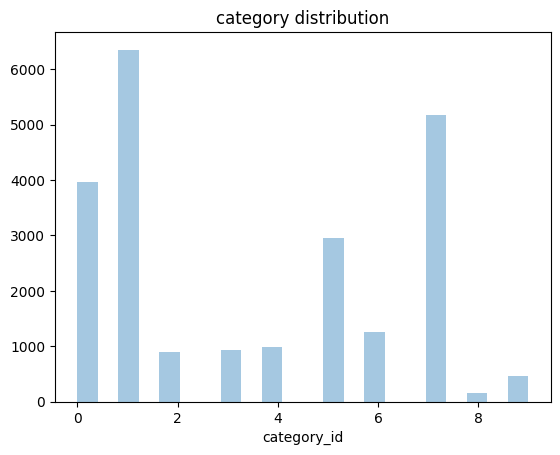

0    3966
1    6352
2     897
3     936
4     982
5    2943
6    1263
7    5178
8     159
9     468
Name: category_id, dtype: int64


In [6]:
category_ids = anno_df['category_id']
sns.distplot(category_ids,kde=False)
plt.title('category distribution')
plt.show()
print(category_ids.value_counts().sort_index())

- object 크기

In [7]:
for category_id in range(10):
    target_area = anno_df[anno_df['category_id'] == category_id]['area']
    print(category_id,':',"mean :",target_area.mean(),"min :",target_area.min(),"max :",target_area.max())

0 : mean : 78860.1473676248 min : 0.56 max : 1048064.06
1 : mean : 92044.19632241812 min : 3.12 max : 1048064.06
2 : mean : 76116.49507246376 min : 66.25 max : 900676.93
3 : mean : 91644.37852564103 min : 275.12 max : 745866.82
4 : mean : 69338.11749490835 min : 666.05 max : 699923.9
5 : mean : 80990.61240910635 min : 105.08 max : 1047961.69
6 : mean : 97589.45237529691 min : 682.95 max : 992374.78
7 : mean : 110357.69823290847 min : 301.71 max : 1048371.21
8 : mean : 50409.96371069182 min : 1639.08 max : 285908.24
9 : mean : 189349.35598290598 min : 867.92 max : 1047961.69


## 

## category per image 

In [8]:
L = [[] for _ in range(len(image_df))]
for _, data  in anno_df.iterrows():
    image_id = data['image_id']
    L[image_id].append(data['category_id'])

image_df = image_df.assign(categories=pd.Series(L).values)
image_df['num_category'] = image_df['categories'].apply(lambda x:len(x))

In [9]:
image_df['num_category'].describe()

count    4883.000000
mean        4.739709
std         6.355155
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max        71.000000
Name: num_category, dtype: float64

In [12]:
image_df[image_df['num_category']>=70]

,width,height,file_name,license,flickr_url,coco_url,date_captured,categories,num_category
id,,,,,,,,,
4197,1024,1024,train/4197.jpg,0,None,None,2021-04-28 12:26:16,"[5, 1, 0, 0, 4, 2, 7, 1, 0, 0, 1, 0, 0, 0, 0, ...",71


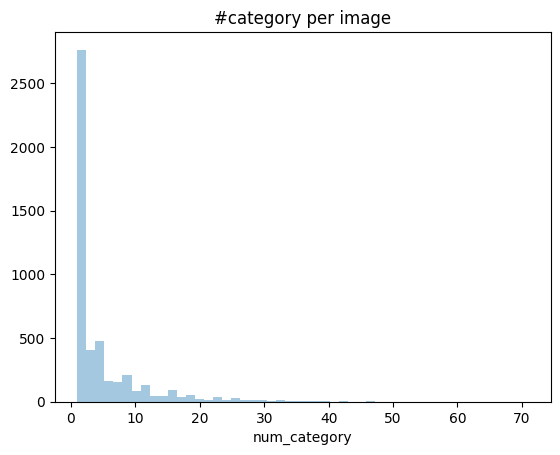

In [10]:
sns.distplot(image_df['num_category'],kde=False)
plt.title('#category per image')
plt.show()

- cdf (cumulative distribution function)

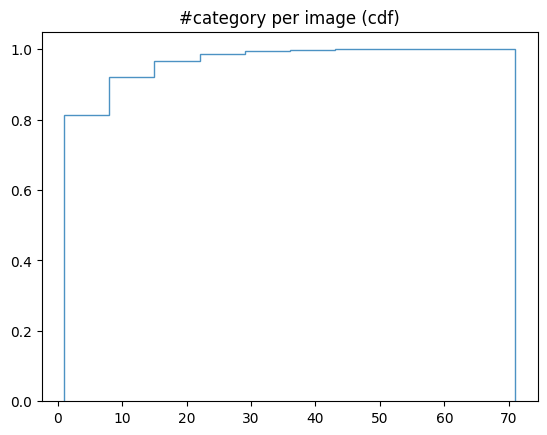

In [10]:
plt.hist(image_df['num_category'], density=True, cumulative=True, label='CDF',histtype='step', alpha=0.8)
plt.title('#category per image (cdf)')
plt.show()

# Bbox Visualizie

In [6]:
image_df.head()

,width,height,file_name,license,flickr_url,coco_url,date_captured
id,,,,,,,
0,1024,1024,train/0000.jpg,0,None,None,2020-12-26 14:44:23
1,1024,1024,train/0001.jpg,0,None,None,2021-01-10 16:30:39
2,1024,1024,train/0002.jpg,0,None,None,2020-12-27 17:55:52
3,1024,1024,train/0003.jpg,0,None,None,2021-03-31 12:10:36
4,1024,1024,train/0004.jpg,0,None,None,2021-01-01 18:52:38


In [7]:
anno_df.head()

,image_id,category_id,area,bbox,iscrowd,id
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4


In [19]:
import os
import cv2

In [39]:
def get_annotated_image(file_name,annotations, root = '../dataset'):
    path = os.path.join(root,file_name)
    img = cv2.imread(path)
    img = cv2.rectangle(img, tuple(tl), tuple(br), rgb, line_thickness)
    return img
    
def plot_image_ids(image_id_list, height_multiplier=6, verbose=True):
    
    for ind, image_id in enumerate(image_id_list):
        annotations = anno_df[anno_df['image_id'] == image_id]
        get_annotated_image(image_df.loc[image_id]['file_name'], annotations)
        
    return
    annotated_imgs = []
    n = len(image_id_list)

    plt.figure(figsize=(20, height_multiplier*n))
    for i, (image_id, annots) in enumerate(annotations.items()):
        if i >= n:
            break
        if verbose:
            print(f".", end="")
        plt.subplot(n//2,2,i+1)
        plt.imshow(self.get_annotated_image(image_id, annots))
        plt.axis(False)
        plt.title(f"Image ID – {image_id}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

In [40]:
plot_image_ids([0,1,2])

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
